<a href="https://colab.research.google.com/github/subodh2708/deep-learning---tensorflow-2.0/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning in tensorflow part 2: fine tuning 

In [1]:
!nvidia-smi


Mon Aug 22 11:37:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-22 11:37:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-22 11:37:24 (84.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-22 11:37:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   201MB/s    in 0.8s    

2022-08-22 11:37:27 (201 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                               image_size=  IMG_SIZE,
                                                               label_mode = "categorical",
                                                               batch_size =  BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images , labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.76244904e+02 1.62244904e+02 1.51959183e+02]
   [1.75250000e+02 1.62178574e+02 1.46443878e+02]
   [1.74255096e+02 1.61612244e+02 1.39397949e+02]
   ...
   [1.08964119e+02 1.00178383e+02 6.70968323e+01]
   [7.34439163e+01 6.10408478e+01 4.04184570e+01]
   [6.48819580e+01 4.78819580e+01 3.91830330e+01]]

  [[1.79280624e+02 1.65280624e+02 1.53086731e+02]
   [1.70448990e+02 1.57377563e+02 1.40729599e+02]
   [1.76632660e+02 1.63989792e+02 1.41775513e+02]
   ...
   [7.07807541e+01 6.32092781e+01 2.76071968e+01]
   [7.17142715e+01 6.25714035e+01 3.38724518e+01]
   [6.93924942e+01 5.69893990e+01 3.63670464e+01]]

  [[1.69311218e+02 1.56882645e+02 1.43658173e+02]
   [1.75336731e+02 1.64265305e+02 1.46408173e+02]
   [1.72724487e+02 1.61510208e+02 1.41081635e+02]
   ...
   [7.38927765e+01 6.78927612e+01 3.70100555e+01]
   [8.05306473e+01 7.45306473e+01 4.05306435e+01]
   [8.22963486e+01 7.32963486e+01 4.18677788e+01]]

  ...

  [[2.28519173e+01 1.88519173e+01 1.82804451e+01]
   [1

## model 0 - Building a transfer learning model using Keras Funcional API

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape= (224,224,3), name= "input_layer")
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f" shape after GlobalAveragePooling2D: {x.shape}")

outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = "output_layers")(x)

model_0 = tf.keras.Model(inputs , outputs)

model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = "transfer learning ",
                                                                         experiment_name = "10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
 shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer learning /10_percent_feature_extraction/20220822-113738
Epoch 1/5
24/24 [==============================] - 20s 170ms/step - loss: 1.9190 - accuracy: 0.3800 - val_loss: 1.3132 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 3s 98ms/step - loss: 1.1544 - accuracy: 0.7427 - val_loss: 0.8869 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 3s 104ms/step - loss: 0.8368 - accuracy: 0.8173 - val_loss: 0.7287 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 3s 100ms/step - loss: 0.6990 - accuracy: 0.8307 - val_loss: 0.6324 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 3s 98ms/step - loss: 0.6003 - accuracy: 0.8427 - val_loss: 0.5891 - val_accuracy: 0.8503


In [12]:
model_0.evaluate(test_data)

79/79 [==============================] - 4s 49ms/step - loss: 0.6058 - accuracy: 0.8408


[0.6057508587837219, 0.8407999873161316]

In [13]:
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


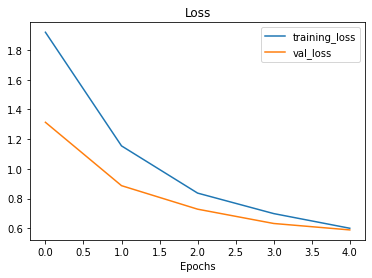

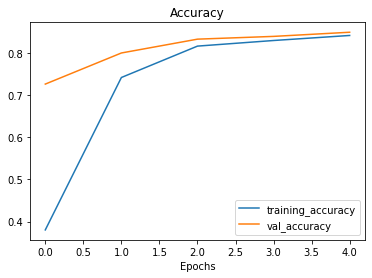

In [16]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

In [17]:
input_shape = (1,4,4,3)

tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"Random input shape: \n {input_tensor} \n ")

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

print(f" shape of input tensor: {input_tensor.shape}")
print(f"shape of global average pooled 2D tenor: {global_average_pooled_tensor.shape}")

Random input shape: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 
 
2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

 shape of input tensor: (1, 4, 4, 3)
shape of global average pooled 2D tenor: (1, 3)


In [18]:
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of experiment  on transfer learning

### Getting and preprocessing the data for model_1

In [19]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-08-22 11:38:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   260MB/s    in 0.5s    

2022-08-22 11:38:15 (260 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
train_dir = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [22]:
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size= BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [23]:
print(tf.__version__)

2.8.2


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [25]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
] , name = "data_augmentation")

(-0.5, 554.5, 461.5, -0.5)

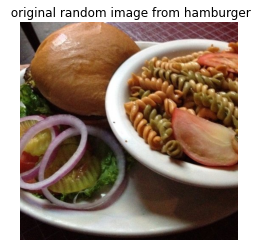

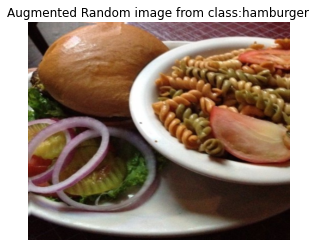

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f" original random image from {target_class}")
plt.axis(False)

augmented_img = data_augmentation(img, training = True)
plt.figure()
plt.imshow((augmented_img)/255)
plt.title(f"Augmented Random image from class:{target_class}")
plt.axis(False)

 ## model_1: feature transfer learning with 1% of data with data augmentation

In [27]:
input_shape = (224,224,3)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

input = layers.Input(shape= input_shape, name = 'input_layers')

x = data_augmentation(input)

x = base_model(x , training = False)

x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = 'softmax', name= 'output_layer')(x)

model_1 = tf.keras.Model(input, outputs)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                         experiment_name = '1_percent_data_augment')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_augment/20220822-114522
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.3861 - accuracy: 0.0857

3/3 [==============================] - 48s 19s/step - loss: 2.3861 - accuracy: 0.0857 - val_loss: 2.2076 - val_accuracy: 0.1908
Epoch 2/5
3/3 [==============================] - 41s 20s/step - loss: 2.1489 - accuracy: 0.2429 - val_loss: 2.0705 - val_accuracy: 0.2911
Epoch 3/5
3/3 [==============================] - 41s 20s/step - loss: 1.9144 - accuracy: 0.4571 - val_loss: 1.9650 - val_accuracy: 0.3816
Epoch 4/5
3/3 [==============================] - 45s 22s/step - loss: 1.7276 - accuracy: 0.5714 - val_loss: 1.8828 - val_accuracy: 0.4145


In [29]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 4s 48ms/step - loss: 1.7746 - accuracy: 0.4956


[1.7746212482452393, 0.49559998512268066]

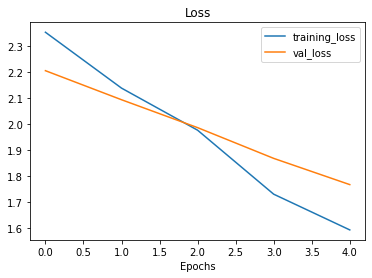

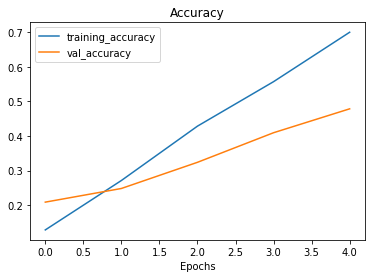

In [31]:
plot_loss_curves(history_1_percent)

## model 2 : feature extraction transfer learning model with 10% data with data augmentation

In [32]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-08-22 11:38:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   191MB/s    in 0.8s    

2022-08-22 11:38:41 (191 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [33]:
unzip_data("10_food_classes_10_percent.zip")

In [34]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [35]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [36]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size =  IMG_SIZE,
                                                                            )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [37]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [38]:
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
],name = "data_augmentation")

In [39]:
input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "input_layers")
x = data_augmentation(inputs)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### creating a model checkpoint callback

In [40]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

In [41]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                          save_weights_only = True,
                                                          save_best_only = False,
                                                          save_freq = 'epoch',
                                                          verbose = 1)

In [42]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                  experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220822-113846
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0305 - accuracy: 0.3333
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 243ms/step - loss: 2.0305 - accuracy: 0.3333 - val_loss: 1.5025 - val_accuracy: 0.6793
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3909 - accuracy: 0.6707
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 170ms/step - loss: 1.3909 - accuracy: 0.6707 - val_loss: 1.0665 - val_accuracy: 0.7681
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0791 - accuracy: 0.7480
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 180ms/step - loss: 1.0791 - accuracy: 0.7480 - val_loss: 0.8838 - val_accuracy: 0.7911
Epo

In [43]:
model_0.evaluate(test_data)

79/79 [==============================] - 4s 48ms/step - loss: 0.6058 - accuracy: 0.8408


[0.6057506799697876, 0.8407999873161316]

In [48]:
result_10_percent_data_aug =model_2.evaluate(test_data)

79/79 [==============================] - 4s 49ms/step - loss: 0.7068 - accuracy: 0.8032


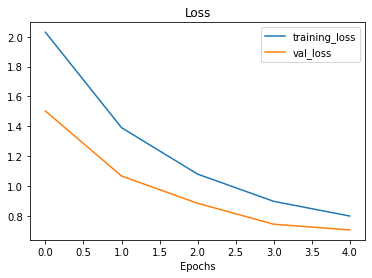

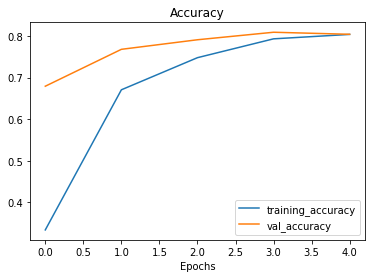

In [49]:
plot_loss_curves(history_10_percent_data_aug)

## loading in checkpoint

In [46]:
model_2.load_weights(checkpoint_path)

In [47]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 4s 48ms/step - loss: 0.7068 - accuracy: 0.8032


In [52]:
result_10_percent_data_aug == loaded_weights_model_results

True

In [53]:
result_10_percent_data_aug

[0.706792950630188, 0.8032000064849854]

In [54]:
loaded_weights_model_results

[0.706792950630188, 0.8032000064849854]

#model 3: Fine-tuning on existing model on 10% of the data

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)

In [ ]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [ ]:
print(len(model_2.layers[2].trainable_variables))

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = ['accuracy'])

In [ ]:
for i , layer in enumerate(model_2.layers[2].layers):
  print(i , layer.name , layer.trainable)

In [ ]:
print(len(model_2.trainable_variables))